# Examination of the impacts of taking a multi model ensemble mean for MIROC; Feb 2024

In [1]:
%reset -f

In [2]:
%load_ext autoreload

In [122]:
%reload_ext autoreload
%autoreload 2

In [4]:
# analysis functions
import xarray as xr
import numpy as np

# plotting functions
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# systems functions
import os

# my own classes and functions
from GradTrendClasses import ModelInput, Trend, TrendPlotting, CalculateMMEGradient, CalculateObsGradient
from GradientProjectFunctions import CropTrendsDf, RemoveClimatology

## Calculating the MM mean of the gradient (i.e., averaging the time series from the distinct inputs)

In [4]:
trendsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Trends'
gradientsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Gradients'

# run a for loop that concatenates all of the input files along the same new dimension ('gradient') then takes the mean along that dimension
os.chdir(gradientsDir)

# get a list of all of the files in the directory (getting rid of the python checkpoints one)
gradientFiles = os.listdir(gradientsDir)
gradientFiles = [f for f in gradientFiles if '.nc' in f]

# now iterate through the list and concatenate them
# adding in another line to check for jump at the concatenation point relative to standard deviation of the historical period

# first initialise an xarray file for concatenation
file1 = xr.open_dataset(gradientFiles[0])
gradientConcat = file1

# have to do the first one manually because of the structure of the for loop
concatJump = []

histStart = '1850-01-16T12:00:00.000000000'
histEnd = '2014-12-16T12:00:00.000000000'
scenStart = '2015-01-16T12:00:00.000000000'
stdHist = file1.sel(time = slice(histStart, histEnd)).std(dim = 'time').ts.item()
jump = (file1.sel(time = histEnd) - file1.sel(time = scenStart)).ts.item()
concatJump.append(jump/stdHist)

for index, file in enumerate(gradientFiles):
    if index > 0:        
        # concatenating the gradients to calculate the mean
        modelGradient = xr.open_dataset(file)
        gradientConcat = xr.concat([gradientConcat, modelGradient], dim = 'gradient')
        
        # calculating the jump relative to std
        stdHist = modelGradient.sel(time = slice(histStart, histEnd)).std(dim = 'time').ts.item()
        jump = (modelGradient.sel(time = histEnd) - modelGradient.sel(time = scenStart)).ts.item()
        concatJump.append(jump/stdHist)
        
# now calculating the mean along the gradient dimension
gradientMean = gradientConcat.mean(dim = 'gradient')

# cutting this off at for the period that we are interested in
gradientMean = gradientMean.ts.sel(time = slice('1850-01-16T12:00:00.000000000', '2022-12-16T12:00:00.000000000'))

/home/hbyrne/miniconda3/envs/hb_1129/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'rasterio' loading failed:
libtbb.so.2: cannot open shared object file: No such file or directory
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


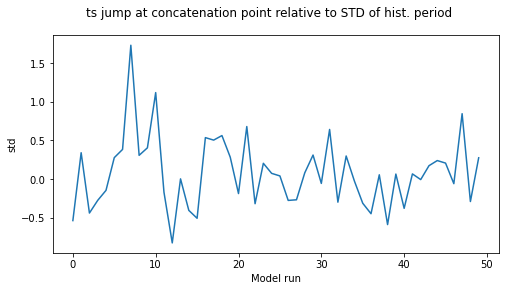

In [5]:
fig = plt.figure(figsize = (8,4))
fig.suptitle('ts jump at concatenation point relative to STD of hist. period')
plt.xlabel('Model run')
plt.ylabel('std')
plt.plot(concatJump)
plt.show()

## Now running the trend class on it

In [8]:
trends = Trend(gradientMeanTest).trends
trendsDf = Trend(gradientMeanTest).trendsDf

## Plotting the trends

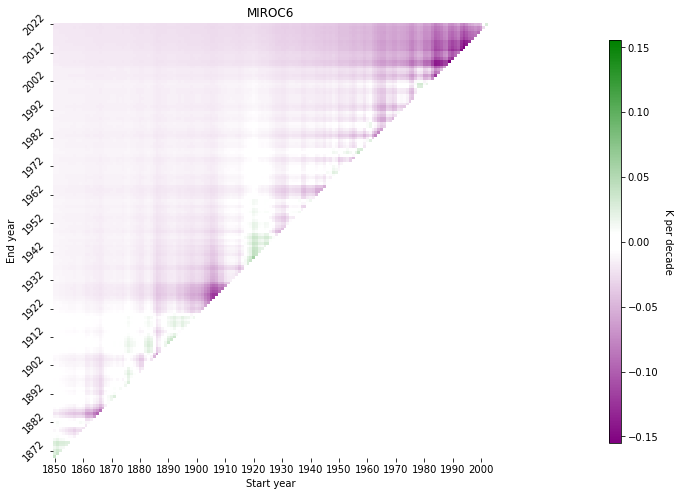

In [145]:
# cropping the trends Df so that plotting doesn't include deadspace
offset = 20 # years
trendsDfCrop = CropTrendsDf(trendsDf, offset)

# calculate the vmin and vmax
vmin = trendsDf.min().min()
vmax = trendsDf.max().max()

# find the absolute values of these to make them symmetrical (if one is positive and the other is negative)
if (vmin < 0) & (vmax > 0):
    limit = max(abs(vmin), abs(vmax))
    vmin = -limit
    vmax = limit
    
# setting the colorbar
colors = [(0,'purple'), (0.48,'white'), (0.52,'white'), (1,'green')]
cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

fig = plt.figure(figsize = (8,8))
axesList = []

ax = fig.add_subplot(111)
ax.set_aspect('equal')
trendPlotter = TrendPlotting(trendsDfCrop, 'MIROC6', vmin, vmax, cmap, norm)
ax = trendPlotter.PlotTrends(ax)  
axesList.append(ax)

cbarAx = fig.add_axes([1.1, 0.15, 0.02, 0.7])
colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
colorBar.set_label('K per decade', rotation = 270, labelpad = 15)

plt.show()

# Observational dataset input and calculation

In [53]:
obsDir = '/home/hbyrne/Research/QMDA_2023'
fileName = 'HadISST_sst 2.nc'
os.chdir(obsDir)

In [115]:
# running the classes on it
modelInput = ModelInput(fileName)

# have to roll the coordinates for Hadley
modelInput = modelInput.ds.assign_coords(lon = ((360 + (modelInput.ds.lon % 360)) % 360))
modelInput = modelInput.roll(lon = int(len(modelInput['lon']) / 2), roll_coords = True)

# remove climatology
modelInput = RemoveClimatology(modelInput)

# calculate the gradient
gradient = CalculateObsGradient(modelInput, 'HadleyISST')

# calculate the trend
trends = Trend(gradient).trends
trendsDf = Trend(gradient).trendsDf

## Plotting the trends

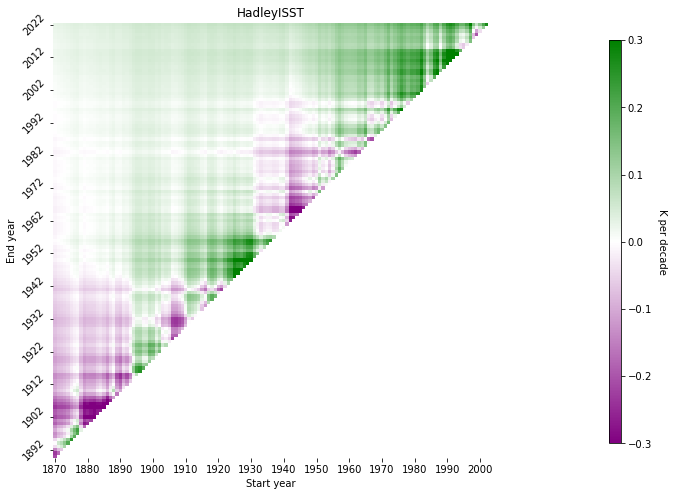

In [123]:
# cropping the trends Df so that plotting doesn't include deadspace
offset = 20 # years
trendsDfCrop = CropTrendsDf(trendsDf, offset)

# calculate the vmin and vmax
vmin = trendsDf.min().min()
vmax = trendsDf.max().max()

# find the absolute values of these to make them symmetrical (if one is positive and the other is negative)
if (vmin < 0) & (vmax > 0):
    limit = max(abs(vmin), abs(vmax))
    vmin = -limit
    vmax = limit
    
vmin = -0.3
vmax = -vmin
    
# setting the colorbar
colors = [(0,'purple'), (0.50,'white'), (1,'green')]
cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

fig = plt.figure(figsize = (8,8))
axesList = []

ax = fig.add_subplot(111)
ax.set_aspect('equal')
trendPlotter = TrendPlotting(trendsDfCrop, 'HadleyISST', vmin, vmax, cmap, norm)
ax = trendPlotter.PlotTrends(ax)  
axesList.append(ax)

cbarAx = fig.add_axes([1.1, 0.15, 0.02, 0.7])
colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
colorBar.set_label('K per decade', rotation = 270, labelpad = 15)

plt.show()

<xarray.Dataset>
Dimensions:    (time: 1840, lat: 180, lon: 360, nv: 2)
Coordinates:
  * time       (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2023-0...
  * lat        (lat) float32 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon        (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 6 7 8 9 10 11 12 1 2 3 4
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float32 -2.794e+04 -2.794e+04 ... 2.794e+04 2.794e+04
    sst        (time, lat, lon) float32 -19.45 -12.96 -12.96 ... nan nan nan
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    5/6/2023 converted to netcdf from pp format
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...